# Analyzing Wine Reviews
Source: https://www.kaggle.com/zynicide/wine-reviews/version/4#winemag-data-130k-v2.csv

The data was scraped from Wine Enthusiast (www.winemag.com) on Nov 22, 2017.
Note that the publication only posts wines that review 80 or higher

### Load libraries

In [1]:
#Importing required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import re
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
import scipy, scipy.stats
# Render our plots inline
%matplotlib inline

## Prepare data

### Import data

In [2]:
df = pd.read_csv('data.csv',index_col=0)

In [3]:
df.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


### Engineer Feature: Year
We will pull the year of the wine from the title column. One thing we have to be careful of is wineries that have years/numbers in their name. In order to circumvent this, we do our best to extract numbers that most likely would result in a year value (4 digits, starts with 1 or 2, second digit is 9 or 0). However we recognize it's not perfect 

In [5]:
df['year'] = df['title'].str.findall('[12][90]\d\d ').str[0]
df.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011


In [6]:
df['year'].isnull().sum()

4626

4626 out of 129971 didn't have years extracted, the equivalent of 3.5% of the sample. Since this is a small proportion, we will leave these NaN values as is.

In [7]:
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['year'].describe()

count    125345.000000
mean       2010.647613
std           6.146649
min        1000.000000
25%        2009.000000
50%        2011.000000
75%        2013.000000
max        2017.000000
Name: year, dtype: float64

We're seeing some really small values for year, which don't make sense. Let's investigate the extreme values.

In [8]:
df.nsmallest(30,'year')

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
30001,US,This approachable wine from the Fetzer organiz...,Bourbon Barrel Aged,91,19.0,California,Mendocino,NaN,Jim Gordon,@gordone_cellars,1000 Stories 2013 Bourbon Barrel Aged Zinfande...,Zinfandel,1000 Stories,1000.0
77996,US,Exotically fruity with an enticing floral char...,Bourbon Barrel Aged Batch No 13,90,19.0,California,California,California Other,Jim Gordon,@gordone_cellars,1000 Stories 2014 Bourbon Barrel Aged Batch No...,Zinfandel,1000 Stories,1000.0
53228,US,"Flavors of green hay, tart juniper berry and g...",NaN,88,25.0,California,Rutherford,Napa,NaN,NaN,1070 Green 2011 Sauvignon Blanc (Rutherford),Sauvignon Blanc,1070 Green,1070.0
56426,France,Exquisite lightness and weightless charm are t...,1904 Cuvée Spéciale Brut,91,40.0,Alsace,Crémant d'Alsace,NaN,Anne Krebiehl MW,@AnneInVino,Arthur Metz NV 1904 Cuvée Spéciale Brut Sparkl...,Sparkling Blend,Arthur Metz,1904.0
9728,Portugal,"With aromas of superripe fruit, this wood aged...",Vinhas Velhas Branco,90,NaN,Douro,NaN,NaN,Roger Voss,@vossroger,1912 Winemakers 2011 Vinhas Velhas Branco Whit...,Portuguese White,1912 Winemakers,1912.0
38689,Portugal,An oak-aged wine that is rich and structured a...,Piorro Reserva,92,NaN,Douro,NaN,NaN,Roger Voss,@vossroger,1912 Winemakers 2009 Piorro Reserva Red (Douro),Portuguese Red,1912 Winemakers,1912.0
41070,Portugal,"This classic blend of Douro grapes is soft, fr...",Piorro Branco Colheita,87,NaN,Douro,NaN,NaN,Roger Voss,@vossroger,1912 Winemakers 2013 Piorro Branco Colheita Wh...,Portuguese White,1912 Winemakers,1912.0
54720,Portugal,"Produced from old vines, this big and rounded ...",Encosta do Bocho Grand Reserva,93,NaN,Douro,NaN,NaN,Roger Voss,@vossroger,1912 Winemakers 2009 Encosta do Bocho Grand Re...,Portuguese Red,1912 Winemakers,1912.0
61105,Portugal,"Made in tanks with no wood aging, this wine fr...",Piorro Colheita,87,NaN,Douro,NaN,NaN,Roger Voss,@vossroger,1912 Winemakers 2011 Piorro Colheita Red (Douro),Portuguese Red,1912 Winemakers,1912.0
72369,Portugal,Made from young vines in the Monteiro family v...,Encosta do Bocho Colheita,88,NaN,Douro,NaN,NaN,Roger Voss,@vossroger,1912 Winemakers 2011 Encosta do Bocho Colheita...,Portuguese Red,1912 Winemakers,1912.0


Looks like our year extractor is getting caught on wineries with numbers in their name. All years 1929 and earlier are affected - 21 rows in total

In [9]:
df = df[df['year'] > 1929]

### Remove unnecessary columns

We will remove the following columns: designation (~30% missing values), region_1 (too specific for high level strategic analysis), region_2 (too specific for high level strategic analysis), taster_twitter_handle (deemed out of scope of our analysis - all reviewers assumed to be unbiased)

In [10]:
df.isnull().sum()

country                     61
description                  0
designation              37157
points                       0
price                     8512
province                    61
region_1                 20685
region_2                 75570
taster_name              25157
taster_twitter_handle    30022
title                        0
variety                      1
winery                       0
year                         0
dtype: int64

In [11]:
df_wine = df.drop(['designation', 'region_1', 'region_2', 'taster_twitter_handle'], 1)
df_wine.head(2)

,country,description,points,price,province,taster_name,title,variety,winery,year
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0


### 1.4 Plot distribution of scores

count    125324.000000
mean         88.485693
std           3.040475
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64


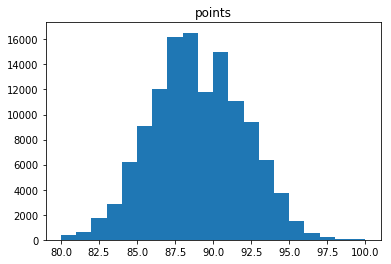

In [12]:
df_wine.hist(column="points", bins = 20, grid = False)
print(df_wine['points'].describe())

## 2.0 Analysis - Which country has the best wines? And which winery within that country?

### 2.1 Which country has the highest wine scores?

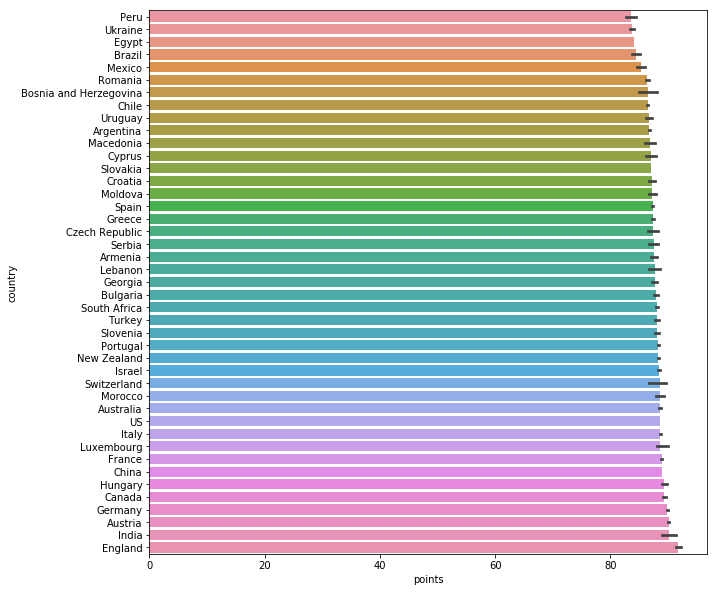

In [13]:
sorter = df_wine.groupby(['country'])['points'].aggregate(np.average).reset_index().sort_values('points')
fig = plt.figure(figsize = (10,10))
sns.barplot(x = 'points', y = 'country', data = df_wine, order=sorter['country'])

From the wines the website has selected to review, England has the best average wine score! 

### 2.2 Which wineries in England have the best wines?

In [14]:
# New dataframe with just wines from England
df_eng = df_wine[df_wine['country'] == 'England']
df_eng.describe()

,points,price,year
count,59.000000,55.000000,59.000000
mean,91.779661,52.400000,2011.949153
std,1.781783,15.780438,1.685882
min,89.000000,25.000000,2009.000000
25%,91.000000,42.000000,2010.000000
50%,91.000000,50.000000,2013.000000
75%,93.500000,58.000000,2013.000000
max,95.000000,95.000000,2015.000000


In [15]:
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 4073 to 128839
Data columns (total 10 columns):
country        59 non-null object
description    59 non-null object
points         59 non-null int64
price          55 non-null float64
province       59 non-null object
taster_name    59 non-null object
title          59 non-null object
variety        59 non-null object
winery         59 non-null object
year           59 non-null float64
dtypes: float64(2), int64(1), object(7)
memory usage: 5.1+ KB


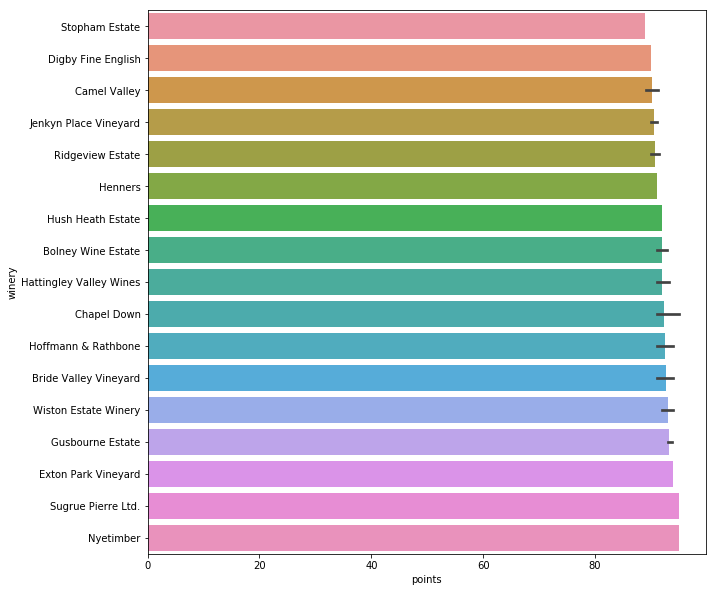

In [16]:
sorter = df_eng.groupby(['winery'])['points'].aggregate(np.average).reset_index().sort_values('points')
fig = plt.figure(figsize = (10,10))
sns.barplot(x = 'points', y = 'winery', data = df_eng, order=sorter['winery'])

In [17]:
# These are the wines from the top wineries in England
df_eng[df_eng['winery'].isin(['Nyetimber','Sugrue Pierre Ltd.','Exton Park Vineyard'])]

,country,description,points,price,province,taster_name,title,variety,winery,year
9909,England,"Touches of vanilla, cream and lovely hints of ...",95,70.0,England,Anne Krebiehl MW,Nyetimber 2010 Blanc de Blancs Chardonnay (Eng...,Chardonnay,Nyetimber,2010.0
60002,England,Beautifully delineated fruit constitues the no...,95,80.0,England,Anne Krebiehl MW,Sugrue Pierre Ltd. 2010 The Trouble with Dream...,Sparkling Blend,Sugrue Pierre Ltd.,2010.0
115329,England,Fragrant overtones of acacia honey play alongs...,94,50.0,England,Anne Krebiehl MW,Exton Park Vineyard 2011 Blanc de Blancs Chard...,Chardonnay,Exton Park Vineyard,2011.0


## 3.0 Analysis - Are expensive wines really better? Are there cheap English wines we can take advantage of?

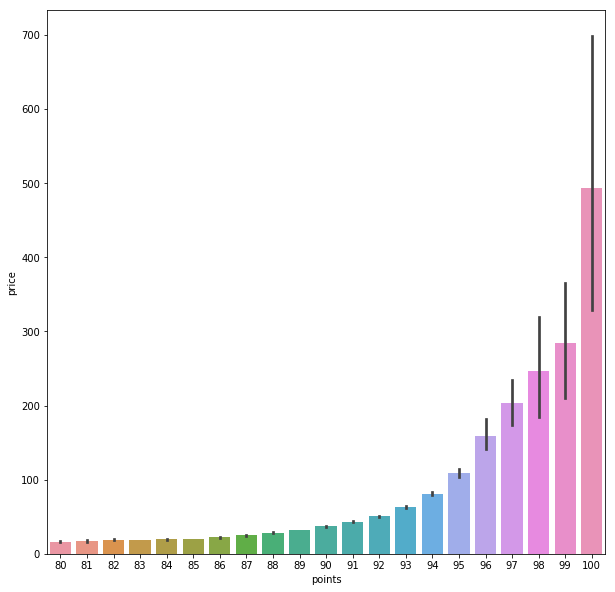

In [18]:
fig = plt.figure(figsize = (10,10))
sns.barplot(x = 'points', y = 'price', data = df_wine)

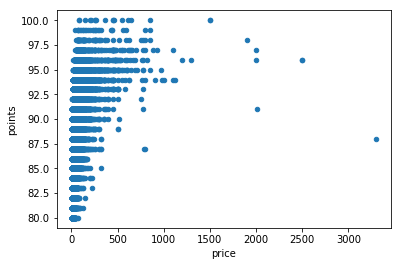

In [19]:
df_wine.plot.scatter(x = 'price', y = 'points')

From the above graphs, better wines are generally more expensive around the world. Does the same relationship hold for England?

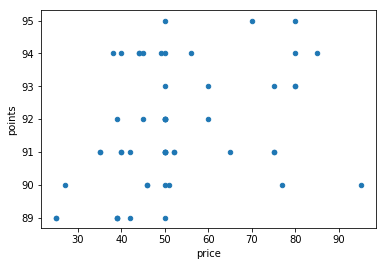

In [20]:
df_eng.plot.scatter(x = 'price', y = 'points')

Looks like the relationship between price and points for English wines is unclear! We can do a linear regression to verify

Null hypothesis: price coefficient = 0 (zero slope, no linear relationship)

Alternative hypothesis: price coefficient is non-zero

alpha = 0.05

In [21]:
df_reg = df_eng.dropna(subset=['price', 'points']) #new df with NaNs removed
df_reg['Eins'] = np.ones(( len(df_reg), ))
Y = df_reg['points']
X = df_reg[['price','Eins']]
result = sm.OLS( Y, X ).fit()
result.summary()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     7.058
Date:                Mon, 24 Dec 2018   Prob (F-statistic):             0.0104
Time:                        11:49:53   Log-Likelihood:                -106.17
No. Observations:                  55   AIC:                             216.3
Df Residuals:                      53   BIC:                             220.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
price          0.0389      0.015      2.657      0.010       0.010       0.068
Eins          89.6695      0.801    111.928      0.000      88.063      91.276
==============================================================================
Omnibus:                        3.003   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.223   Jarque-Bera (JB):                1.881
Skew:                           0.218   Prob(JB):                        0.390
Kurtosis:                       2.206   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since P = 0.01 < 0.05, we reject the null hypothesis and conclude there is a linear relationship between price and points for English wines

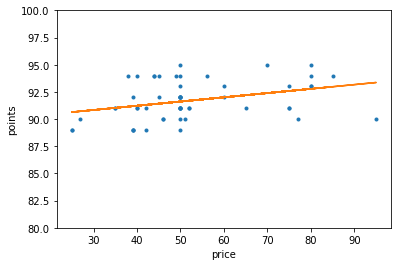

In [22]:
x = np.arange(10)
plt.plot(df_reg.price, df_reg.points, '.')
plt.plot(df_reg.price, 89.6695 + 0.0389 * df_reg.price, '-')
plt.xlabel('price')
plt.ylabel('points')
plt.ylim(80,100)
plt.show()

However, looking at the figure, we know there are some cheap wines that are reviewed much better than others at the same price. We can identify those:

In [23]:
df_eng[df_eng['points'] == 94].sort_values(by=['price'])

,country,description,points,price,province,taster_name,title,variety,winery,year
103174,England,"A lifting mix of golden, ripe apple, chamomile...",94,38.0,England,Anne Krebiehl MW,Ridgeview Estate 2009 South Ridge Cuvée Merret...,Sparkling Blend,Ridgeview Estate,2009.0
115311,England,A toasty touch of brioche joins ripe red and y...,94,40.0,England,Anne Krebiehl MW,Wiston Estate Winery 2013 Cuvée Brut Sparkling...,Sparkling Blend,Wiston Estate Winery,2013.0
70579,England,Both the fruit and the aromatic foliage of wil...,94,44.0,England,Anne Krebiehl MW,Wiston Estate Winery 2011 Rosé Sparkling (Engl...,Sparkling Blend,Wiston Estate Winery,2011.0
115312,England,Evocative redcurrant notes play on the nose. T...,94,44.0,England,Anne Krebiehl MW,Wiston Estate Winery 2014 Rosé Sparkling (Engl...,Sparkling Blend,Wiston Estate Winery,2014.0
70597,England,"Gentle white blossom, white currant and Golden...",94,45.0,England,Anne Krebiehl MW,Hattingley Valley Wines 2010 Blanc de Blancs C...,Chardonnay,Hattingley Valley Wines,2010.0
103173,England,Sophisticated aromas of Golden Pearmain apples...,94,49.0,England,Anne Krebiehl MW,Wiston Estate Winery 2010 Blanc de Blancs Char...,Chardonnay,Wiston Estate Winery,2010.0
115329,England,Fragrant overtones of acacia honey play alongs...,94,50.0,England,Anne Krebiehl MW,Exton Park Vineyard 2011 Blanc de Blancs Chard...,Chardonnay,Exton Park Vineyard,2011.0
84241,England,A touch of blossom honey enriches the tart but...,94,56.0,England,Anne Krebiehl MW,Hoffmann & Rathbone 2011 Blanc de Blancs Chard...,Chardonnay,Hoffmann & Rathbone,2011.0
84240,England,A restrained but pure note of lemon constitute...,94,80.0,England,Anne Krebiehl MW,Gusbourne Estate 2013 Blanc de Blancs Chardonn...,Chardonnay,Gusbourne Estate,2013.0
115319,England,Restrained notes of tart red berry and pink gr...,94,85.0,England,Anne Krebiehl MW,Bride Valley Vineyard 2014 Rosé Bella Sparklin...,Sparkling Blend,Bride Valley Vineyard,2014.0


## 4.0 Analysis - Were there certain years in England that produced better wine?
Note that we don't know what year the wine was reviewed, only the year it was processed

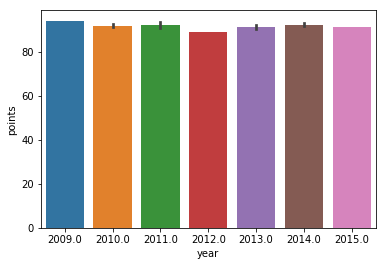

In [24]:
sns.barplot(x = 'year', y = 'points', data = df_eng)

2009 was a good year, and 2012 is perhaps a year to avoid

## 5.0 Analysis - Are there any taste-related nominations that are likely to occur in the description of higher-/lower-scoring wines?

In [25]:
df_descr = df_wine.drop(['year', 'taster_name', 'price', "country", "variety", "province", "title", "winery"], 1)
df_descr['description'] = df_descr['description'].str.lower()

In [26]:
df_top = df_descr[df_descr['points'] <= 90]
df_bot = df_descr[df_descr['points'] > 90]

In [27]:
#the top half.
f = open("flavour.txt")
l = []
d={}
counter = 0

for line in f:
    line.split()
    line = line.strip()
    l.append(line)
d = {el:0 for el in l}
#adding each element of the list to a new dictionary, the value being the number of occurrences
for descr in df_top['description']:
    counter +=1
    k = descr.split()
    for word in k:
        if word in d:
            d[word]+= 1
import operator
d.update((x, y/counter*100) for x, y in d.items())#calculating the percentage
df_meta_1 = pd.DataFrame(list(d.items()),
                      columns=['Flavour','Percentage_T'])
df_meta_1 = df_meta_1.sort_values(by=['Percentage_T'], ascending = False)
df_meta_1 = df_meta_1.reset_index()
df_meta_1 = df_meta_1[['Flavour', "Percentage_T"]].copy()
df_meta_1.head(50)

,Flavour,Percentage_T
0,fruit,22.545844
1,drink,18.166654
2,cherry,13.498262
3,berry,9.810123
4,plum,7.964429
5,crisp,7.892941
6,apple,7.519253
7,dry,7.448848
8,sweet,7.306955
9,citrus,7.161812


In [28]:
#the bottom half
f = open("flavour.txt")
l = []
d={}
counter = 0

for line in f:
    line.split()
    line = line.strip()
    l.append(line)
d = {el:0 for el in l}
for descr in df_bot['description']:
    counter +=1
    k = descr.split()
    for word in k:
        if word in d:
            d[word]+= 1
import operator
d.update((x, y/counter*100) for x, y in d.items())
df_meta_2 = pd.DataFrame(list(d.items()),
                      columns=['Flavour','Percentage_B'])

df_meta_2 = df_meta_2.sort_values(by=['Percentage_B'], ascending = False)
df_meta_2 = df_meta_2.reset_index()
df_meta_2 = df_meta_2[['Flavour', "Percentage_B"]].copy()
df_meta_2.head(50)

,Flavour,Percentage_B
0,drink,29.014272
1,fruit,25.190146
2,cherry,12.802642
3,blackberry,7.845217
4,dried,7.636132
5,plum,7.105845
6,berry,6.775552
7,dry,6.530105
8,sweet,6.357383
9,pepper,5.814975


In [29]:
merged_Frame = pd.merge(df_meta_1,df_meta_2, on = "Flavour")
merged_Frame.columns = ["Flavour", "Percentage_High_Score", "Percentage_Low_Score"]

merged_Frame['Percentage_High_Score'] = merged_Frame.Percentage_High_Score.round(2)
merged_Frame['Percentage_Low_Score'] = merged_Frame.Percentage_Low_Score.round(2)
merged_Frame=merged_Frame.head(40)
merged_Frame

,Flavour,Percentage_High_Score,Percentage_Low_Score
0,fruit,22.55,25.19
1,drink,18.17,29.01
2,cherry,13.50,12.80
3,berry,9.81,6.78
4,plum,7.96,7.11
5,crisp,7.89,4.72
6,apple,7.52,4.83
7,dry,7.45,6.53
8,sweet,7.31,6.36
9,citrus,7.16,5.05


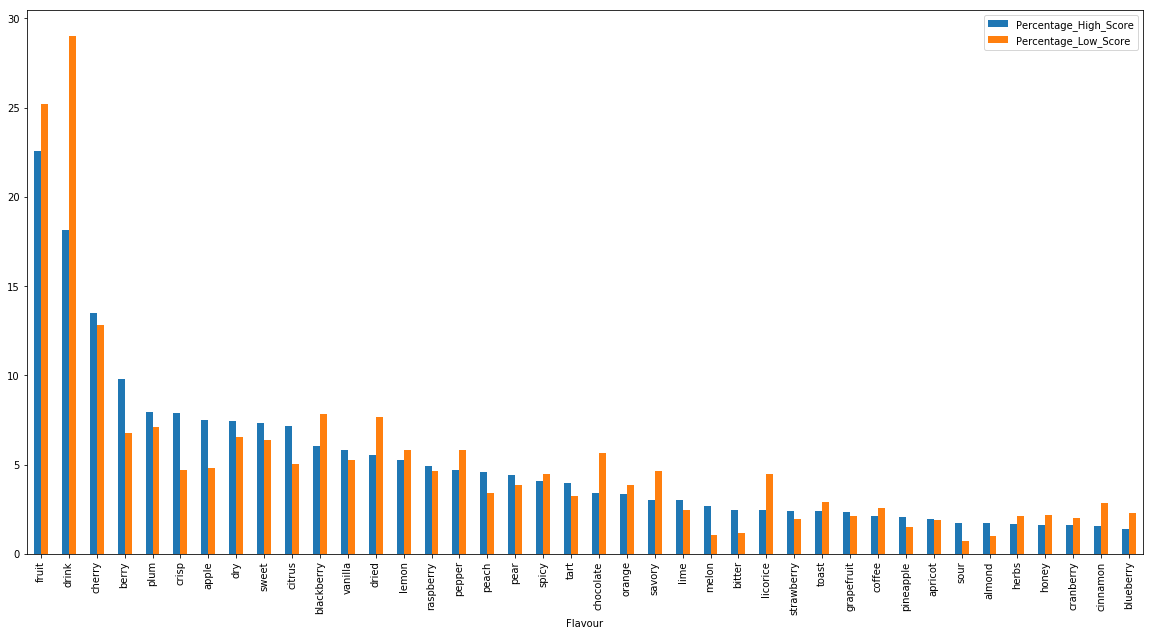

In [30]:
merged_Frame.plot(x="Flavour", y=["Percentage_High_Score", "Percentage_Low_Score"], kind="bar", figsize=(20,10))